In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord 
from astropy.nddata import Cutout2D
from astropy.time import Time
import astropy.units as u
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch
from matplotlib.widgets import Slider, TextBox
import lsdb
from dask.distributed import Client
print('imported libraries')

imported libraries


In [3]:
# Set target coordinates and cutout size
target_coord = SkyCoord(ra=202.951993 * u.deg, dec=-1.285494 * u.deg, frame='icrs')
cutout_size = 10 * u.arcsec
fits_dir = "../../../../shared/hsc_images_ra=202.95deg_dec=-1.28deg_radius=0.02deg/"

# Proper motion data (mas/yr)
ra = 202.951993
dec = -1.285494
pm_ra = -414.209178     # in mas/yr
pm_dec = -1041.278255   # in mas/yr
print('defined vars')

defined vars


In [4]:
def rotate_vector(v, theta, origin=(0, 0)):
    """
    Rotate point v by angle theta around origin.
    
    Parameters:
        v: array-like, shape (2,)
        theta: float, angle in radians
        origin: array-like, shape (2,), the center of rotation

    Returns:
        Rotated vector as a NumPy array
    """
    v = np.array(v)
    origin = np.array(origin)
    
    # Translate to origin
    translated = v - origin
    
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    
    # Rotate and translate back
    rotated = np.matmul(rotation_matrix, translated) + origin
    return rotated


Running loop
202.951993 -1.285494 -414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


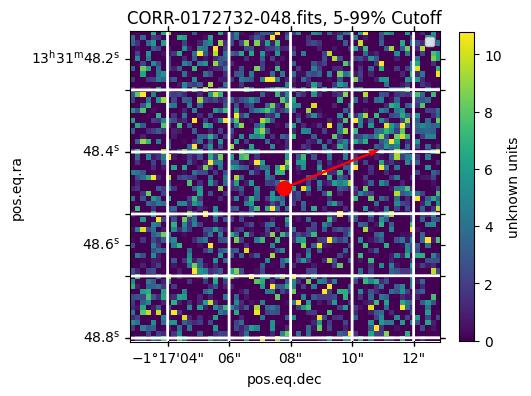

202.951993 -1.285494 -414.209178 -1041.278255
-414.209178 -1041.278255
-414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


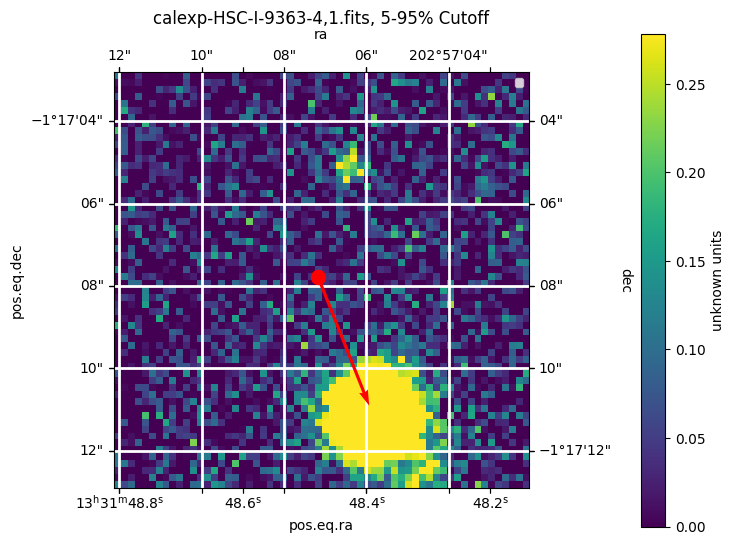

202.951993 -1.285494 -414.209178 -1041.278255
three_years: <SkyCoord (ICRS): (ra, dec) in deg
    (202.95164765, -1.28636173)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-414.31359265, -1041.27819868, 0.04888835)>


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/tmp/ipykernel_101471/3642505215.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


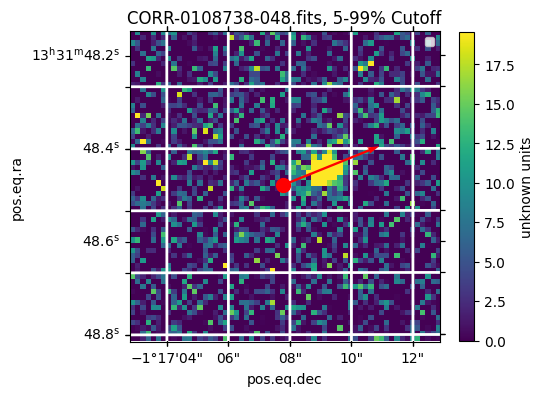

completed loop


In [34]:
print('Running loop')
# Loop through all FITS files
for fname in os.listdir(fits_dir):
    if ((not fname == 'CORR-0172732-048.fits') and
     (not fname == 'calexp-HSC-I-9363-4,1.fits') and 
     (not fname == 'CORR-0108738-048.fits')):
        continue
    fpath = os.path.join(fits_dir, fname)
    try:
        with fits.open(fpath) as hdul:
            for hdu in hdul:
                if hdu.data is not None:
                    try:
                        wcs = WCS(hdu.header)
                        cutout = Cutout2D(hdu.data, target_coord, cutout_size, wcs=wcs)
                        print(ra, dec, pm_ra, pm_dec)

                        im_ra, im_dec, im_pm_ra, im_pm_dec = ra, dec, pm_ra, pm_dec
                        pad = 0.05
                        figsize = (5, 5)
                        title_pad=6
                        lower_cutoff = 5
                        upper_cutoff = 99

                        if 'calexp' in fpath: 
                            print(im_pm_ra, im_pm_dec)
                            # im_pm_ra, im_pm_dec = rotate_vector((im_pm_ra, im_pm_dec), 90, origin=(im_ra, im_dec))
                            print(im_pm_ra, im_pm_dec)
                            # cutout.data = np.rot90(cutout.data, k=3)
                            pad = 0.18
                            figsize = (8,8)
                            title_pad = 35
                            upper_cutoff = 95
                            
                        ra_cos_dec = im_pm_ra / np.cos(np.radians(im_dec))
                        pm_star = SkyCoord(ra=ra * u.deg, 
                                           dec=dec * u.deg, 
                                           pm_ra_cosdec=ra_cos_dec*u.mas/u.yr, 
                                           pm_dec=pm_dec*u.mas/u.yr,
                                           obstime=Time('J2016')
                        )   
                        
                        # Convert to pixel position on the cutout WCS
                        origin = skycoord_to_pixel(pm_star, cutout.wcs)
                    
                        three_years = pm_star.apply_space_motion(new_obstime=Time('J2019'))
                        print(f'three_years: {three_years}')
                        end_vec = skycoord_to_pixel(three_years, cutout.wcs)
                        
                        # Make the plot
                        fig = plt.figure(figsize=figsize)
                        ax = fig.add_subplot(111, projection=cutout.wcs)
                        vmin, vmax = np.percentile(cutout.data, [lower_cutoff, upper_cutoff])
                        im = ax.imshow(cutout.data, origin='lower', cmap='viridis', vmin=0, vmax=vmax)
                        ax.set_title(f'{fname}, {lower_cutoff}-{upper_cutoff}% Cutoff', pad=title_pad)

                        # Overlay
                        overlay = ax.get_coords_overlay('icrs')
                        overlay.grid(color='white', linestyle='solid', alpha=1, linewidth=2, zorder=1)

                        # Colorbar
                        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=pad, shrink=0.8)
                        unit = hdu.header.get('BUNIT', 'unknown units')
                        cbar.set_label(unit)

                        # Plot Vector
                        vec = np.array(end_vec) - np.array(origin)
                        ax.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
                        ax.plot(*origin, marker='o', color='red', markersize=10, zorder=10)
                        ax.legend(loc='upper right', fontsize=8)
                        
                        plt.show()
                        break
                    except Exception as e:
                        if str(e) != 'Arrays do not overlap.' and str(e) != 'WCS should contain celestial component':
                            print(f"[Inner Error] {fname}: {e}")
                        continue
    except Exception as e:
        print(f"[Outer Error] Skipped {fname}: {e}")
print('completed loop')

In [15]:
%%time
with Client():
    hsc_p3_r = (
        lsdb.read_hats('../../../../shared/hats/catalogs/hsc_pdr3/hsc_pdr3-forced-R', 
        margin_cache='../../../../shared/hats/catalogs/hsc_pdr3/hsc_pdr3-forced-R_10arcs')
        .cone_search(ra=ra, dec=dec, radius_arcsec=8).compute()
    )
hsc_p3_r

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39211 instead
  warnings.warn(
2025-06-05 14:16:54,662 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


CPU times: user 3.66 s, sys: 1.46 s, total: 5.13 s
Wall time: 4min 32s


,id,coord_ra,coord_dec,parent,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_TransformedCentroid_x,base_TransformedCentroid_y,base_InputCount_value,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_TransformedShape_xx,base_TransformedShape_yy,base_TransformedShape_xy,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureFlux_25_0_instFluxErr,base_CircularApertureFlux_35_0_instFlux,base_CircularApertureFlux_35_0_instFluxErr,base_CircularApertureFlux_50_0_instFlux,base_CircularApertureFlux_50_0_instFluxErr,base_CircularApertureFlux_70_0_instFlux,base_CircularApertureFlux_70_0_instFluxErr,base_GaussianFlux_instFlux,base_GaussianFlux_instFluxErr,base_LocalBackground_instFlux,base_LocalBackground_instFluxErr,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_Variance_value,ext_photometryKron_KronFlux_instFlux,ext_photometryKron_KronFlux_instFluxErr,ext_photometryKron_KronFlux_radius,ext_photometryKron_KronFlux_radius_for_radius,ext_photometryKron_KronFlux_psf_radius,ext_convolved_ConvolvedFlux_seeing,ext_convolved_ConvolvedFlux_0_3_3_instFlux,ext_convolved_ConvolvedFlux_0_3_3_instFluxErr,ext_convolved_ConvolvedFlux_0_4_5_instFlux,ext_convolved_ConvolvedFlux_0_4_5_instFluxErr,ext_convolved_ConvolvedFlux_0_6_0_instFlux,ext_convolved_ConvolvedFlux_0_6_0_instFluxErr,ext_convolved_ConvolvedFlux_0_kron_instFlux,ext_convolved_ConvolvedFlux_0_kron_instFluxErr,ext_convolved_ConvolvedFlux_1_3_3_instFlux,ext_convolved_ConvolvedFlux_1_3_3_instFluxErr,ext_convolved_ConvolvedFlux_1_4_5_instFlux,ext_convolved_ConvolvedFlux_1_4_5_instFluxErr,ext_convolved_ConvolvedFlux_1_6_0_instFlux,ext_convolved_ConvolvedFlux_1_6_0_instFluxErr,ext_convolved_ConvolvedFlux_1_kron_instFlux,ext_convolved_ConvolvedFlux_1_kron_instFluxErr,ext_convolved_ConvolvedFlux_2_3_3_instFlux,ext_convolved_ConvolvedFlux_2_3_3_instFluxErr,ext_convolved_ConvolvedFlux_2_4_5_instFlux,ext_convolved_ConvolvedFlux_2_4_5_instFluxErr,ext_convolved_ConvolvedFlux_2_6_0_instFlux,ext_convolved_ConvolvedFlux_2_6_0_instFluxErr,ext_convolved_ConvolvedFlux_2_kron_instFlux,ext_convolved_ConvolvedFlux_2_kron_instFluxErr,ext_convolved_ConvolvedFlux_3_3_3_instFlux,ext_convolved_ConvolvedFlux_3_3_3_instFluxErr,ext_convolved_ConvolvedFlux_3_4_5_instFlux,ext_convolved_ConvolvedFlux_3_4_5_instFluxErr,ext_convolved_ConvolvedFlux_3_6_0_instFlux,ext_convolved_ConvolvedFlux_3_6_0_instFluxErr,ext_convolved_ConvolvedFlux_3_kron_instFlux,ext_

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


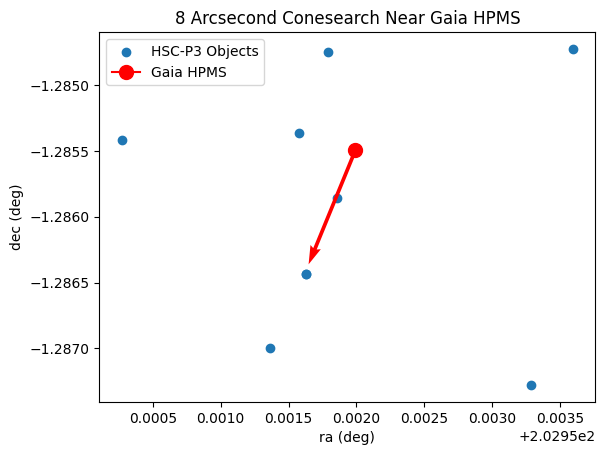

In [32]:
# Find Gaia Star and Motion:
years = 3
pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))
coord = SkyCoord(ra=ra * u.deg,
                 dec=dec * u.deg,
                 pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                 pm_dec=pm_dec * u.mas/u.yr,
                 obstime='J2020')      # reference epoch

new_coord = coord.apply_space_motion(dt=years * u.yr)

# Plot stars
plt.scatter(hsc_p3_r['coord_ra'], hsc_p3_r['coord_dec'], label='HSC-P3 Objects')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('8 Arcsecond Conesearch Near Gaia HPMS')

# Plot Gaia Star
origin = coord.ra.deg, coord.dec.deg
predicted_pos = new_coord.ra.deg, new_coord.dec.deg
vec = np.array(predicted_pos) - np.array(origin) 
plt.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
plt.plot(*origin, marker='o', color='red', markersize=10, zorder=10, label='Gaia HPMS')
plt.legend()

In [35]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
from numpy.core.defchararray import startswith
import numpy as np
import pylab as plt
import matplotlib
%matplotlib inline

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac
print('imported libraries')

/var/tmp/ipykernel_101471/588140120.py:8: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.startswith.
  from numpy.core.defchararray import startswith


imported libraries


In [36]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

Enter user name: (+ENTER)  joaopassos
Enter password: (+ENTER)  ········


'joaopassos'

In [67]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2_se"
des_dr2 = sia.SIAService(DEF_ACCESS_URL)
ra = 42.817451981441494 # in degrees
dec = -3.8882601693023133 # in degrees
pm_ra = 1112.662482
pm_dec = -1853.859953
fov = 0.0022 # in degrees (~10 arcsecs)

In [68]:
imgTable = des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00710668_g_c28_r3518p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14532,,,3,0,0,2,[2048 4096],,,[-0.13168],,des_dr2_se,,DES DR2,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00710668_g_c28_r3518p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00710668_g_c28_r3518p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.712,-3.95354,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00700339_z_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14501,,,3,0,0,2,[2048 4096],,,[-0.13174],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00700339_z_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00700339_z_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.7124,-3.95293,--,,,--,-9.42906e-41,9.42906e-41,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14456,,,3,0,0,2,[2048 4096],,,[-0.13173],,des_dr2_se,,DES DR2,archival,,,DECam,i DECam SDSS c0003 7835.0 1470.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00692095_i_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.713,-3.95132,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DES DR2,0,IMAGE,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14456,,,3,0,0,2,[2048 4096],,,[-0.13173],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00692095_i_c28_r3517p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00692095_i_c28_r3517p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.00

In [69]:
sel = (imgTable['proctype'].astype(str)=='Stack') & (startswith(imgTable['obs_bandpass'].astype(str),'r'))

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


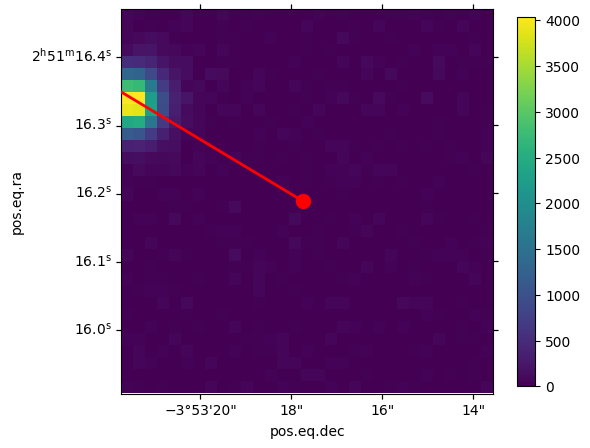

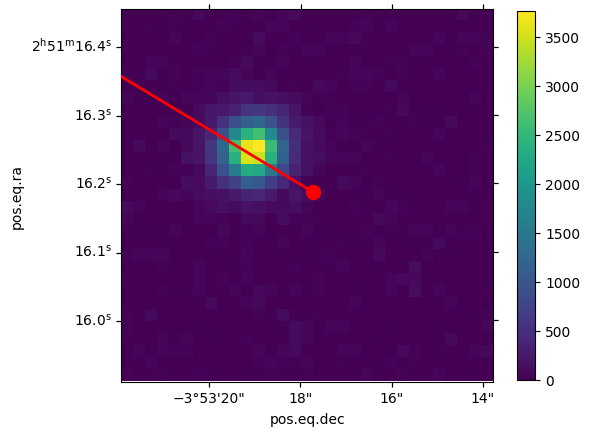

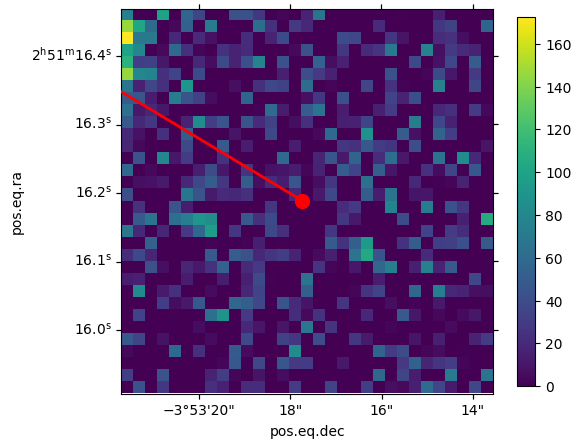

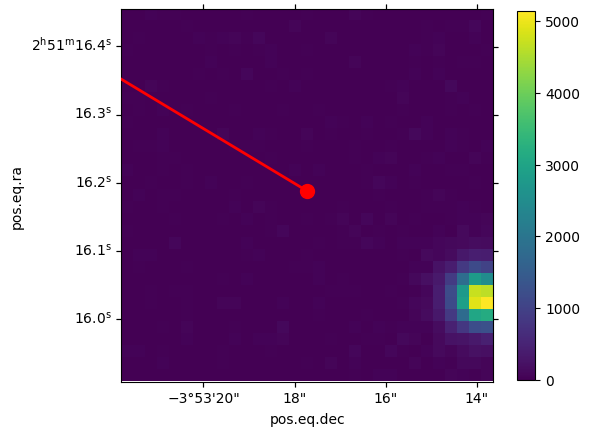

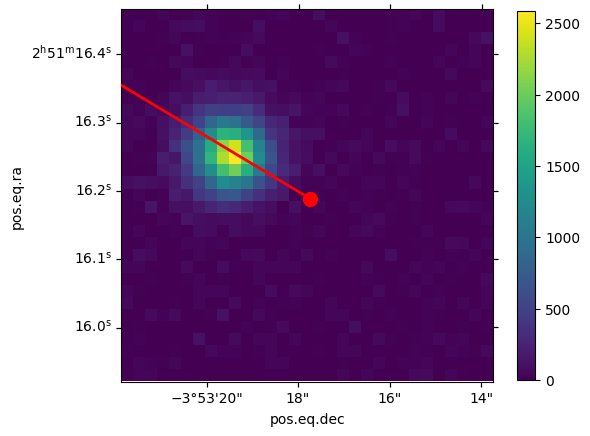

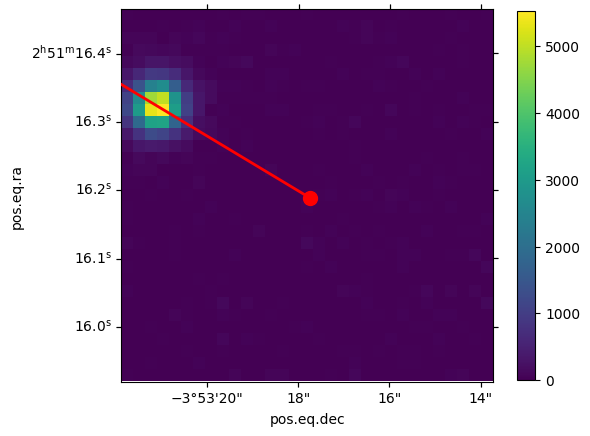

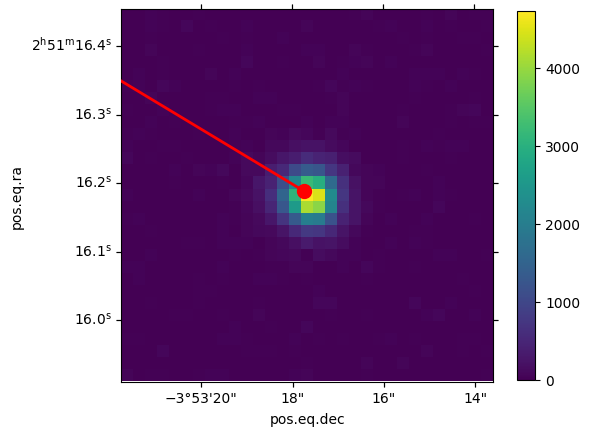

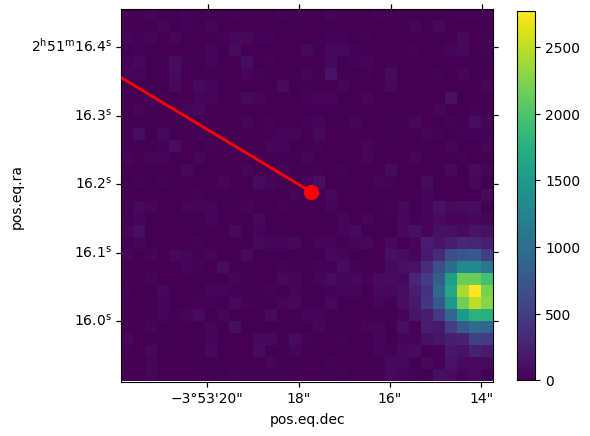

In [70]:
pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))

coord = SkyCoord(ra=ra * u.deg,
                 dec=dec * u.deg,
                 pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                 pm_dec=pm_dec * u.mas/u.yr, obstime='J2013')

new_coord = coord.apply_space_motion(new_obstime=Time('J2017'))


for row in imgTable[sel]:
    try:
        # Get Data
        url = row['access_url']
        filename = download_file(url,cache=True,show_progress=False,timeout=120)
        hdu = fits.open(filename)[0]
        image = hdu.data
        hdr = hdu.header
        wcs = WCS(hdr) 

        #Create plot
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection=wcs)
        im = plt.imshow(image, vmin=0)
        cbar = plt.colorbar(im, orientation='vertical', shrink=0.8)
        
        # Plot Point
        end_vec = skycoord_to_pixel(new_coord, wcs)
        origin = skycoord_to_pixel(coord, wcs)
        vec = np.array(end_vec) - np.array(origin)
        plt.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
        plt.plot(*origin, marker='o', color='red', markersize=10, zorder=10)

        plt.show()
    except Exception as e:
        print(f'Failed to run, error:{str(e)}')

In [73]:
%%time
with Client():
    des_dr2 = (
        lsdb.read_hats('../../../../shared/hats/catalogs/des/des_dr2')
        .cone_search(ra=ra, dec=dec, radius_arcsec=8).compute()
    )
des_dr2

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44477 instead
  warnings.warn(
2025-06-05 16:11:32,493 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


CPU times: user 3.77 s, sys: 1.86 s, total: 5.63 s
Wall time: 4min 48s


,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,GALACTIC_L,GALACTIC_B,XWIN_IMAGE,YWIN_IMAGE,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_J2000,ERRTHETA_IMAGE,KRON_RADIUS,EBV_SFD98,MAG_AUTO_G_DERED,MAG_AUTO_R_DERED,MAG_AUTO_I_DERED,MAG_AUTO_Z_DERED,MAG_AUTO_Y_DERED,WAVG_MAG_PSF_G_DERED,WAVG_MAG_PSF_R_DERED,WAVG_MAG_PSF_I_DERED,WAVG_MAG_PSF_Z_DERED,WAVG_MAG_PSF_Y_DERED,EXTENDED_CLASS_COADD,EXTENDED_CLASS_WAVG,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,XWIN_IMAGE_G,XWIN_IMAGE_R,XWIN_IMAGE_I,XWIN_IMAGE_Z,XWIN_IMAGE_Y,YWIN_IMAGE_G,YWIN_IMAGE_R,YWIN_IMAGE_I,YWIN_IMAGE_Z,YWIN_IMAGE_Y,X2WIN_IMAGE_G,X2WIN_IMAGE_R,X2WIN_IMAGE_I,X2WIN_IMAGE_Z,X2WIN_IMAGE_Y,Y2WIN_IMAGE_G,Y2WIN_IMAGE_R,Y2WIN_IMAGE_I,Y2WIN_IMAGE_Z,Y2WIN_IMAGE_Y,XYWIN_IMAGE_G,XYWIN_IMAGE_R,XYWIN_IMAGE_I,XYWIN_IMAGE_Z,XYWIN_IMAGE_Y,ERRX2WIN_IMAGE_G,ERRX2WIN_IMAGE_R,ERRX2WIN_IMAGE_I,ERRX2WIN_IMAGE_Z,ERRX2WIN_IMAGE_Y,ERRY2WIN_IMAGE_G,ERRY2WIN_IMAGE_R,ERRY2WIN_IMAGE_I,ERRY2WIN_IMAGE_Z,ERRY2WIN_IMAGE_Y,ERRXYWIN_IMAGE_G,ERRXYWIN_IMAGE_R,ERRXYWIN_IMAGE_I,ERRXYWIN_IMAGE_Z,ERRXYWIN_IMAGE_Y,AWIN_IMAGE_G,AWIN_IMAGE_R,AWIN_IMAGE_I,AWIN_IMAGE_Z,AWIN_IMAGE_Y,BWIN_IMAGE_G,BWIN_IMAGE_R,BWIN_IMAGE_I,BWIN_IMAGE_Z,BWIN_IMAGE_Y,THETAWIN_IMAGE_G,THETAWIN_IMAGE_R,THETAWIN_IMAGE_I,THETAWIN_IMAGE_Z,THETAWIN_IMAGE_Y,ERRAWIN_IMAGE_G,ERRAWIN_IMAGE_R,ERRAWIN_IMAGE_I,ERRAWIN_IMAGE_Z,ERRAWIN_IMAGE_Y,ERRBWIN_IMAGE_G,ERRBWIN_IMAGE_R,ERRBWIN_IMAGE_I,ERRBWIN_IMAGE_Z,ERRBWIN_IMAGE_Y,ERRTHETAWIN_IMAGE_G,ERRTHETAWIN_IMAGE_R,ERRTHETAWIN_IMAGE_I,ERRTHETAWIN_IMAGE_Z,ERRTHETAWIN_IMAGE_Y,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,FLUX_RADIUS_Y,FWHM_IMAGE_G,FWHM_IMAGE_R,FWHM_IMAGE_I,FWHM_IMAGE_Z,FWHM_IMAGE_Y,ISOAREA_IMAGE_G,ISOAREA_IMAGE_R,ISOAREA_IMAGE_I,ISOAREA_IMAGE_Z,ISOAREA_IMAGE_Y,BACKGROUND_G,BACKGROUND_R,BACKGROUND_I,BACKGROUND_Z,BACKGROUND_Y,NITER_MODEL_G,NITER_MODEL_R,NITER_MODEL_I,NITER_MODEL_Z,NITER_MODEL_Y,KRON_RADIUS_G,KRON_RADIUS_R,KRON_RADIUS_I,KRON_RADIUS_Z,KRON_RADIUS_Y,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Z,FLUXERR_AUTO_Y,WAVG_FLUX_PSF_G,WAVG_FLUX_PSF_R,WAVG_FLUX_PSF_I,WAVG_FLUX_PSF_Z,WAVG_FLUX_PSF_Y,WAVG_FLUXERR_PSF_G,WAVG_FLUXERR_PSF_R,WAVG_FLUXERR_PSF_I,WAVG_FLUXERR_PSF_Z,WAVG_FLUXERR_PSF_Y,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_SPREAD_MODEL_G,WAVG_SPREAD_MODEL_R,WAVG_SPREAD_MODEL_I,WAVG_SPREAD_MODEL_Z,WAVG_SPREAD_MODEL_Y,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y,Norder,Dir,Npix
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2592746699573430477,1344189302,b'DES0252-0333',9211,36845,9432357,150917720,2414683531,42.81831,-3.889707,42.81831,-3.889707,179.112869,-53.151863,7921.199129,388.127847,3.083973,0.011458,2.949814,0.010666,69.698997,-84.861382,3.5,0.03783,24.844992,21.280657,19.123371,17.010584,18.202335,-99.0,-99.0,-99.0,-99.0,-99.0,3,-9,3,0,0,3,0,0,3,0,0,3,0,0,3,0,0,7920.838481,7921.161436,7921.049055,7921.217549,7921.285855,387.087341,388.12466,387.863668,388.158109,388.178937,2.47258,2.856859,2.496836,1.919008,9.413209,2.125154,2.936219,2.532926,1.805021,8.799083,0.029371,0.166421,0.15094

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


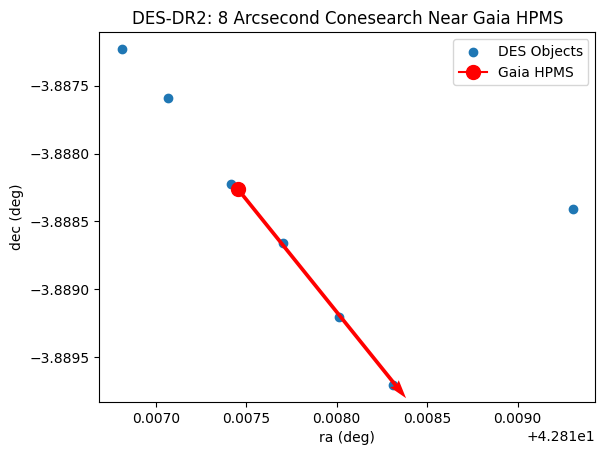

In [74]:
# Find Gaia Star and Motion:
years = 3
pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))
coord = SkyCoord(ra=ra * u.deg,
                 dec=dec * u.deg,
                 pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                 pm_dec=pm_dec * u.mas/u.yr,
                 obstime='J2020')      # reference epoch

new_coord = coord.apply_space_motion(dt=years * u.yr)

# Plot stars
plt.scatter(des_dr2['RA'], des_dr2['DEC'], label='DES Objects')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('DES-DR2: 8 Arcsecond Conesearch Near Gaia HPMS')

# Plot Gaia Star
origin = coord.ra.deg, coord.dec.deg
predicted_pos = new_coord.ra.deg, new_coord.dec.deg
vec = np.array(predicted_pos) - np.array(origin) 
plt.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
plt.plot(*origin, marker='o', color='red', markersize=10, zorder=10, label='Gaia HPMS')
plt.legend()